The code in the "Package WeakL" and "Time-varying WeakL" paragraphs is the definition of the required functions for the Additive WeakL and Online WeakL models.

"Use case 1: GAM-Viking to WeakL" contains the code that generates the WeakL model, which is a direct translation of the offline GAM formula of [[1]](#1) into the WeakL framework.
- In **Validation offline**, the offline additive WeakL hyperparameters are tuned by grid search. The estimated effects for a given hour _h_ can be visualised with the *print_effect()* function
- **Generate additive WeakL** calculates the forecast of the offline model for each instant. One can visualise the forecast error for a given hour _h_ and the mean absolute error (MAE) for each hour computed over the test period.
- **Time-varying WeakL** generates the online adaptation of the offline WeakL error. Again, the hyperparameters are tuned by grid search in **Validation online**. In addition, we compute the intraday correction used in [[1]](#1) and generate two csv files, one with the forecasts of the offline model and the other with the forecasts after the online adaptation, after the intraday correction.

## References
<a id="1">[1]</a>
De Vilmarest, J. and Goude, Y., 2022. State-space models for online post-covid electricity load forecasting competition. IEEE Open Access Journal of Power and Energy, 9, pp.192-201.


In [47]:
# Allows to automatically switch from CPU to GPU
from datetime import timedelta
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def is_running_on_gpu():
  if torch.cuda.is_available():
    print("The algorithm is running on GPU.")
  else:
    print("The algorithm is not running on GPU.")

In [48]:
is_running_on_gpu()

The algorithm is running on GPU.


In [49]:
type_float64 = True

if type_float64:
  torch.set_default_dtype(torch.float64)
  np_dtype = np.float64
else:
  torch.set_default_dtype(torch.float32)
  np_dtype = np.float32

## Package WeakL

### Additive model

In [50]:
def normalize(dataset):
    data_min, data_max = np.min(dataset, axis=0), np.max(dataset, axis=0)
    center = (data_min+data_max)/2
    amplitude = data_max-data_min
    amplitude.replace(0, 1, inplace=True)
    return (dataset - center)/amplitude*2*torch.pi

def Sob_elementary(alpha, s, m):
    Sob_elem = torch.cat((torch.arange(-m, 0, device=device), torch.arange(1, m+1, device=device)))
    return alpha*(1+Sob_elem**(2*s))

def Sob_matrix(alpha_list, s_list, m_list):
    d = len(s_list)
    total_length = 1+sum(1 if m == 'Linear' else 2 * m for m in m_list)
    Sob_diag = torch.zeros(total_length, device=device)
    Sob_diag[0] = alpha_list[0]
    idx = 1
    for i in range(d):
        if m_list[i] == 'Linear':
            Sob_diag[idx] = alpha_list[i + 1]
            idx += 1
        else:
            Sob_diag[idx:idx + 2*m_list[i]] = Sob_elementary(alpha_list[i + 1], s_list[i], m_list[i])
            idx += 2*m_list[i]
    return torch.diag(Sob_diag)


def mat_frequency(m_list, n):
    total_length = 1+sum(2 * m if m != "Linear" else 1 for m in m_list)
    frequencies = torch.zeros(total_length, device=device)

    idx = 1
    for m in m_list:
        if m == "Linear":
            idx += 1
        else:
            frequencies[idx:idx + m] = torch.arange(-m, 0, device=device)
            frequencies[idx + m:idx + 2 * m] = torch.arange(1, m + 1, device=device)
            idx += 2 * m
    return torch.tile(frequencies, (n, 1))

def mat_linear(x_data, m_list, n):
    d = len(m_list)
    total_columns = 1+sum(1 if m == 'Linear' else 2 * m for m in m_list)
    mat = torch.zeros(n, total_columns, device=device)
    col_idx = 1
    for i in range(d):
        if m_list[i] == 'Linear':
            mat[:, col_idx] = x_data[:, i] - 1
            col_idx += 1
        else:
            col_idx += 2 * m_list[i]
    return mat

def mat_data(x_data, m_list, n):
    d = len(m_list)
    total_columns = 1+sum(1 if m == 'Linear' else 2 * m for m in m_list)
    mat = torch.zeros(n, total_columns, device=device)

    col_idx = 1
    for i in range(d):
        if m_list[i] == 'Linear':
            mat[:, col_idx] = x_data[:, i]
            col_idx += 1
        else:
            mat[:, col_idx:col_idx + 2 * m_list[i]] = torch.tile(x_data[:, i].view(-1, 1), (1, 2 * m_list[i]))
            col_idx += 2 * m_list[i]
    return mat


def phi_matrix(x_data, m_list):
    n = len(x_data)
    return torch.exp(-1j*torch.mul(mat_data(x_data, m_list, n),mat_frequency(m_list, n))/2)+mat_linear(x_data, m_list, n)

def regression_vector(x_data, y_data, m_list, alpha_list, s_list):
    covariance_matrix_X = torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1))@phi_matrix(x_data, m_list)
    covariance_XY = torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1))@y_data
    M = Sob_matrix(alpha_list, s_list, m_list)
    return torch.linalg.solve(covariance_matrix_X+len(x_data)*M, covariance_XY)

def estimation(fourier_coefs, z_data, m_list):
    fourier_coefs = fourier_coefs
    return phi_matrix(z_data, m_list)@fourier_coefs


# A améliorer pour envoyer sur GPU
def transform(df, m_list, fourier_vector, features):
    g_h = pd.DataFrame()
    g_h['Load'] = df['Load']
    g_h['Time']=df['Time']
    g_h['WeakL'] = torch.real(estimation(fourier_vector, torch.tensor(df[features].values, device=device), m_list)).view(-1).cpu().numpy()
    g_h["error"]=df["Load"]-g_h['WeakL']
    phi_mat = phi_matrix(torch.tensor(df[features].values, device=device), m_list)

    current = 1
    for j in range(len(features)):
        if m_list[j]=="Linear":
            linear_coeff = fourier_vector[current].cpu()
            g_h[features[j]] = linear_coeff*torch.tensor(df[features[j]].values).view(-1)
            current+= 1
        elif m_list[j] < 1:
            g_h[features[j]] = 0*1j
        else:
            partial_fourier = fourier_vector[current:current+2*m_list[j]]
            g_h[features[j]] = (phi_mat[:, current:current+2*m_list[j]]@partial_fourier).view(-1).cpu()
            current+= 2*m_list[j]
    return g_h



### Grid search WeakL

In [51]:
def calculate_total_length(m_list):
    return 1 + sum(2 * m if m != "Linear" else 1 for m in m_list)

def mat_frequency_h(m_list, n):
    total_length = calculate_total_length(m_list)
    frequencies = torch.zeros(total_length, device=device)

    idx = 1
    for m in m_list:
        if m == "Linear":
            idx += 1
        else:
            freq_range = torch.arange(1, m + 1, device=device)
            frequencies[idx:idx + m] = -freq_range.flip(0)
            frequencies[idx + m:idx + 2 * m] = freq_range
            idx += 2 * m
    return frequencies.unsqueeze(0).unsqueeze(0)

def mat_linear_h(x_data, m_list):
    batch_size, n, d = x_data.shape
    total_columns = calculate_total_length(m_list)
    mat = torch.zeros(batch_size, n, total_columns, device=device)

    col_idx = 1
    for i, m in enumerate(m_list):
        if m == 'Linear':
            mat[:, :, col_idx] = x_data[:, :, i] - 1
            col_idx += 1
        else:
            col_idx += 2 * m
    return mat

def mat_data_h(x_data, m_list):
    batch_size, n, d = x_data.shape
    total_columns = calculate_total_length(m_list)
    mat = torch.zeros(batch_size, n, total_columns, device=device)

    col_idx = 1
    for i, m in enumerate(m_list):
        if m == 'Linear':
            mat[:, :, col_idx] = x_data[:, :, i]
            col_idx += 1
        else:
            repeated_data = x_data[:, :, i].unsqueeze(2).expand(batch_size, n, 2 * m)
            mat[:, :, col_idx:col_idx + 2 * m] = repeated_data
            col_idx += 2 * m
    return mat

def phi_matrix_h(x_data, m_list):
    batch_size = x_data.size(0)
    n = x_data.size(1)
    return torch.exp(-1j * mat_data_h(x_data, m_list) * mat_frequency_h(m_list, n) / 2) + mat_linear_h(x_data, m_list)


In [52]:
def cov_hourly_m(m_list, data_hourly):
    cov_hourly = []
    x_data, x_test, y_data, ground_truth = data_hourly

    phi_mat = phi_matrix_h(x_data, m_list)
    covariance_matrix_X = torch.bmm(phi_mat.transpose(1, 2).conj(), phi_mat)
    covariance_XY = torch.bmm(phi_mat.transpose(1, 2).conj(), y_data)
    phi_mat_z = phi_matrix_h(x_test, m_list)

    return covariance_matrix_X, covariance_XY, phi_mat_z, ground_truth

def regression_vector_grid(covariance_matrix_X, covariance_XY, M):
    return torch.linalg.solve(covariance_matrix_X+M, covariance_XY)

In [53]:
def hour_formatting(data, date, features_weakl):
    begin_train, end_train, end_test = date["begin_train"], date["end_train"], date["end_test"]
    features, features1, features2 = features_weakl["features_union"], features_weakl["features1"], features_weakl["features2"]
    data_hourly = []

    for h in range(24):
        data_h = data[data['Hour']==h]

        data_h.loc[:,features]=normalize(data_h.loc[:,features]).loc[:,features]
        df_train = data_h[(data_h['Time']>= begin_train)&(data_h['Time']<end_train)]
        df_test = data_h[(data_h['Time']>= end_train)&(data_h['Time']<end_test)]

        if h<8:
            x_data = torch.tensor(df_train[features1].values, device=device)
            x_test = torch.tensor(df_test[features1].values, device=device)
        else :
            x_data = torch.tensor(df_train[features2].values, device=device)
            x_test = torch.tensor(df_test[features2].values, device=device)

        y_data = torch.tensor(df_train['Load'].values, device=device).view(-1,1)*(1+0*1j)
        ground_truth = torch.tensor(df_test['Load'].values, device=device)

        if type_float64:
          data_hourly.append([x_data, x_test, y_data, ground_truth])
        else:
          data_hourly.append([x_data.to(torch.float32), x_test.to(torch.float32), y_data.to(torch.complex64), ground_truth.to(torch.float32)])

    x_data = torch.stack([data_hourly[i][0] for i in range(24)])
    x_test = torch.stack([data_hourly[i][1] for i in range(24)])
    y_data = torch.stack([data_hourly[i][2] for i in range(24)])
    ground_truth = torch.stack([data_hourly[i][3] for i in range(24)])
    return x_data, x_test, y_data, ground_truth


In [54]:
def sob_effects(features_weakl, m_list, s_list, n):
    features_type = features_weakl["features_type"]
    n_param = len(features_type)+1
    one_list = [1. for i in range(n_param)]
    select_dim = [[0 for i in range(n_param)] for i in range(n_param)]
    for i in range(n_param):
        select_dim[i][i] = 1
    sobolev_effects = []
    for i in range(n_param):
        sobolev_effects.append(Sob_matrix(select_dim[i], s_list, m_list))
    sobolev_effects = torch.stack(sobolev_effects)*n
    return sobolev_effects

In [55]:
def WeakL(data, hyperparameters, cov_hourly, M_stacked):
    m_list, s_list, alpha_list = hyperparameters["m_list"], hyperparameters["s_list"], hyperparameters["alpha_list"]

    fourier_vectors= torch.linalg.solve(cov_hourly[0]+M_stacked, cov_hourly[1])
    estimators = torch.matmul(cov_hourly[2], fourier_vectors).squeeze(-1)
    mae_houlry = torch.mean(torch.abs(estimators-cov_hourly[3]), dim=1)
    mae = torch.mean(mae_houlry)
    return mae, fourier_vectors, mae_houlry

In [56]:
def create_grid(features_weakl, n, grid_parameters):
    features_type = features_weakl["masked"]
    grid_size_m, grid_size_p, grid_step_p = grid_parameters["grid_size_m"], grid_parameters["grid_size_p"], grid_parameters["grid_step_p"]
    number_regression = 0

    m_range, alpha_const, alpha_grid_range, s_list = [], [[10**(-30)]], [], [] # Initializing power with the offset
    for feature_type in features_type:
        if feature_type == "masked":
            m_range.append(["Linear"]), alpha_const.append([10**(10)]), s_list.append("*")
        elif feature_type in ["bool", "linear"]:
            m_range.append(["Linear"]), alpha_const.append([10**(-30)]), s_list.append("*")
        elif feature_type[:11] == "categorical":
            n_categories = int(feature_type[11:])
            m_range.append([n_categories//2+n_categories%2]), alpha_const.append([10**(-30)]), s_list.append(0)
        elif feature_type == "regression":
            m_ini = grid_parameters["m_ini"]
            power_ini = -int(np.log(n)/np.log(10))
            m_possibilities = list(range(m_ini-grid_size_m, m_ini+grid_size_m+1))

            power_possibilities = np.arange(power_ini-grid_size_p*grid_step_p, power_ini+(grid_size_p+1)*grid_step_p, grid_step_p)
            m_range.append(m_possibilities), alpha_grid_range.append(10**power_possibilities), s_list.append(2)
            number_regression+=1
    grid_m = list(itertools.product(*m_range))

    grid_a = torch.cartesian_prod(*torch.tensor(np.array(alpha_grid_range, dtype=np_dtype), device=device)).view(-1, number_regression, 1, 1)
    alpha_const = torch.tensor(alpha_const, device=device).view(-1, 1, 1)

    regression_mask = [i+1 for i in range(len(features_type)) if features_type[i] == "regression"]
    non_reg_mask = [0]+[i+1 for i in range(len(features_type)) if features_type[i] != "regression"]
    return grid_m, alpha_const, grid_a, s_list, regression_mask, non_reg_mask


def grid_search_weakl(data, date, features_weakl, n, grid_parameters):
    grid_m, alpha_const, grid_a, s_list, regression_mask, non_reg_mask = create_grid(features_weakl, n, grid_parameters)
    len_grid_m, len_grid_a, counter = len(grid_m), len(grid_a), 0

    grid_a = grid_a.split(grid_parameters["batch_size"], dim=0)
    batch_number = len(grid_a)

    mae_min = torch.inf
    mae_h=[]
    m_list_opt, power_list_opt, mae_list_opt, fourier_opt = [], [], [], []
    alpha_list_opt = torch.tensor([], device=device)

    data_hourly = hour_formatting(data, date, features_weakl)

    for m_list in grid_m:
      cov_hourly = cov_hourly_m(m_list, data_hourly)

      sobolev_effects = sob_effects(features_weakl, m_list, s_list, len(data_hourly[0][0]))
      mul1 = alpha_const*(sobolev_effects[non_reg_mask,:].unsqueeze(0))

      counter_batch =0
      print(str(counter*len_grid_a)+"/"+str(len_grid_m*len_grid_a))

      for grid_a_batch in grid_a:
        print("Batch: "+ str(counter_batch)+"/"+str(batch_number))
        counter_batch+=1

        mul2 = grid_a_batch*(sobolev_effects[regression_mask,:].unsqueeze(0))
        sobolev_matrices = torch.sum(mul1, dim=1, keepdim=True) + torch.sum(mul2, dim=1, keepdim=True)
        fourier_vectors= torch.linalg.solve(cov_hourly[0].unsqueeze(0)+sobolev_matrices, cov_hourly[1].unsqueeze(0))
        estimators = torch.matmul(cov_hourly[2].unsqueeze(0), fourier_vectors).squeeze(-1)
        errors = torch.abs(cov_hourly[3].unsqueeze(0)-estimators)
        mae_hourly =  torch.mean(errors, dim=2)
        mae_mean = torch.mean(mae_hourly, dim=1)
        min_mae_index = torch.argmin(mae_mean)

        if mae_mean[min_mae_index] < mae_min:
              m_list_opt, alpha_list_opt, mae_opt, fourier_opt, mae_h = m_list, grid_a_batch[min_mae_index], mae_mean[min_mae_index], fourier_vectors[min_mae_index], mae_hourly[min_mae_index]
              mae_min = mae_mean[min_mae_index]
      counter+=1
    alpha_opt = torch.zeros(len(regression_mask)+len(non_reg_mask), device=device)
    alpha_opt[regression_mask] = alpha_list_opt.view(-1)
    alpha_opt[non_reg_mask] = alpha_const.view(-1)
    return m_list_opt, alpha_opt, s_list, mae_opt, fourier_opt, mae_h


### Significativité des effets

In [57]:
def P_matrix(x_data, m_list, alpha_list, s_list):
    covariance_matrix_X = torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1))@phi_matrix(x_data, m_list)
    M = Sob_matrix(alpha_list, s_list, m_list)
    return torch.linalg.solve(covariance_matrix_X+len(x_data)*M, torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1)))

def sigma_estimate(x_data, m_list, alpha_list, s_list, fourier_vector, y_data):
    n = len(x_data)
    P = P_matrix(x_data, m_list, alpha_list, s_list)
    tr = torch.real(torch.trace(phi_matrix(x_data, m_list)@P))
    interpolation = torch.real(estimation(fourier_vector, x_data, m_list)).view(-1)
    err = torch.sum(torch.square(torch.abs(interpolation-y_data.view(-1)))).item()
    return 1/(n-tr)*err

def t_test(x_data, m_list, alpha_list, s_list, fourier_vector, y_data):
    t_stat = []
    P = P_matrix(x_data, m_list, alpha_list, s_list)
    mat = P@phi_matrix(x_data, m_list)@ torch.conj_physical(torch.transpose(phi_matrix(x_data, m_list), 0,1))@ torch.conj_physical(torch.transpose(P, 0,1))
    sigma = sigma_estimate(x_data, m_list, alpha_list, s_list, fourier_vector, y_data).item()
    for i in range(len(fourier_vector)):
        t_stat.append(fourier_vector[i].item()/np.sqrt(mat[i,i].item()*sigma))
    return np.array(t_stat)

def print_t_test(test, features, m_list):
    print("--------------------------")
    print("T-tests")
    print("Offset: t-test = "+str(np.abs(test[0])), ", significant (5%) = "+ str(np.abs(test[0]) > 2))
    index = 0
    for i in range(len(features)):
        print('Feature '+ features[i])
        if m_list[i]=='Linear':
            index+=1
            print("Linear coefficient t-test = "+str(np.abs(test[index])), ", significant (5%) = "+ str(np.abs(test[index]) > 2))
        else:
            for j in range(2*m_list[i]):
                index+=1
                print("Fourier coefficient "+str(j)+" t-test = "+str(np.abs(test[index])), ", significant (5%) = "+ str(np.abs(test[index]) > 2))
    print("--------------------------")
    return

In [58]:
def print_effect(data, dates, features_weakl, hyperparameters, fourier_vectors, h):
    m_list, s_list, alpha_list = hyperparameters["m_list"], hyperparameters["s_list"], hyperparameters["alpha_list"]
    begin_train, end_train = dates["begin_train"], dates["end_train"]

    if h<8:
        features = features_weakl["features1"]
    else:
        features = features_weakl["features2"]

    df_h = data[data['Hour'] == h]
    df_h=df_h[features+['Load','Time']]
    df_h.loc[:,features]=normalize(df_h[features]).loc[:,features]
    df_h = df_h[(df_h['Time']>= begin_train)&(df_h['Time']<end_train)]

    x_data = torch.tensor(df_h[features].values, device=device)
    y_data = torch.tensor(df_h['Load'].values, device=device).view(-1,1)*(1+0*1j)
    test=t_test(x_data, m_list, alpha_list, s_list, fourier_vectors[h], y_data)
    # print_t_test(test, features, m_list)

    g_h=transform(df_h, m_list, fourier_vectors[h], features)

    for feature in features:
        print(feature)
        plt.figure()
        plt.scatter(df_h[feature], np.real(g_h[feature]))
        plt.show()




## Time-varying WeakL

In [59]:
def calculate_total_length(m_list):
    return 1 + sum(2 * m if m != "Linear" else 1 for m in m_list)

def mat_frequency_online(m_list):
    total_length = calculate_total_length(m_list)
    frequencies = torch.zeros(total_length, device=device)

    idx = 1
    for m in m_list:
        if m == "Linear":
            idx += 1
        else:
            freq_range = torch.arange(1, m + 1, device=device)
            frequencies[idx:idx + m] = -freq_range.flip(0)
            frequencies[idx + m:idx + 2 * m] = freq_range
            idx += 2 * m

    return frequencies.unsqueeze(0).unsqueeze(0).unsqueeze(0)

def mat_linear_online(x_data, m_list):
    batch_size, steps, n, d = x_data.shape
    total_columns = calculate_total_length(m_list)
    mat = torch.zeros(batch_size, steps, n, total_columns, device=device)

    col_idx = 1
    for i, m in enumerate(m_list):
        if m == 'Linear':
            mat[:, :, :, col_idx] = x_data[:, :, :, -1] - 1
            col_idx += 1
        else:
            col_idx += 2 * m
    return mat

def mat_data_online(x_data, m_list):
    batch_size, steps, n, d = x_data.shape
    total_columns = calculate_total_length(m_list)
    mat = torch.zeros(batch_size, steps, n, total_columns, device=device)

    mat[:, :, :, 0] = 1

    col_idx = 1
    for i, m in enumerate(m_list):
        if m == 'Linear':
            mat[:, :, :, col_idx] = x_data[:, :, :, i]
            col_idx += 1
        else:
            repeated_data = x_data[:, :, :, i].unsqueeze(-1).expand(batch_size, steps, n, 2 * m)
            mat[:, :, :, col_idx:col_idx + 2 * m] = repeated_data
            col_idx += 2 * m
    return mat


def mat_time_online(x_data, m_list):
    batch_size, steps, n, d = x_data.shape
    total_columns = calculate_total_length(m_list)
    mat = torch.zeros(batch_size, steps, n, total_columns, device=device)

    col_idx = 1
    for i, m in enumerate(m_list):
        if m == 'Linear':
            mat[:, :, :, col_idx] = x_data[:, :, :, -1]
            col_idx += 1
        else:
            repeated_data = x_data[:, :, :, -1].unsqueeze(-1).expand(batch_size, steps, n, 2 * m)
            mat[:, :, :, col_idx:col_idx + 2 * m] = repeated_data
            col_idx += 2 * m
    return mat

def phi_matrix_online(x_data, m_list):
    return  mat_data_online(x_data, m_list) *(torch.exp(-1j * mat_time_online(x_data, m_list)* mat_frequency_online(m_list) / 2) + mat_linear_online(x_data, m_list))


In [60]:
def cov_hourly_online(m_list, data_hourly):
    cov_hourly = []
    x_data, x_test, y_data, ground_truth = data_hourly

    phi_mat = phi_matrix_online(x_data, m_list)
    covariance_matrix_X = torch.matmul(phi_mat.transpose(2, 3).conj(), phi_mat)
    covariance_XY = torch.matmul(phi_mat.transpose(2, 3).conj(), y_data)
    phi_mat_z = phi_matrix_online(x_test, m_list)

    return covariance_matrix_X, covariance_XY, phi_mat_z, ground_truth

In [61]:
def hour_formatting_online(data, date, features_weakl, hyperparameters):
    begin_train, end_train, end_test = date["begin_train"], date["end_train"], date["end_test"]
    features, features1, features2 = features_weakl["features_union"], features_weakl["features1"], features_weakl["features2"]
    fourier_vectors = hyperparameters["fourier_vectors"]
    m_list = hyperparameters["m_list"]
    window = hyperparameters["window"]
    data_hourly = []

    for h in range(24):
        x_online_list, x_test_list, y_online_list=[],[],[]

        data_h = data[data['Hour']==h]

        data_h.loc[:,features]=normalize(data_h.loc[:,features]).loc[:,features]

        if h<8:
            g_h=transform(data_h, m_list, fourier_vectors[h], features1)
            g_h.loc[:,features1]=normalize(g_h.loc[:,features1]).loc[:,features1]

        else:
            g_h=transform(data_h, m_list, fourier_vectors[h], features2)
            g_h.loc[:,features2]=normalize(g_h.loc[:,features2]).loc[:,features2]

        current_end_train = pd.to_datetime(end_train)
        current_end_test = current_end_train+timedelta(days=window)
        g_h['Time']=pd.to_datetime(g_h['Time'])

        learning_window = len(g_h[(g_h['Time']>=begin_train)&(g_h['Time']<current_end_train)])

        while current_end_train < pd.to_datetime(end_test):
            g_train = g_h[(g_h['Time']>=begin_train)&(g_h['Time']<current_end_train)]
            g_test = g_h[(g_h['Time']>=current_end_train)&(g_h['Time']<current_end_test)]
            if h<8:
                x_online = torch.tensor(g_train[features1].values, device=device)
                x_test_online = torch.tensor(g_test[features1].values, device=device)
            else:
                x_online = torch.tensor(g_train[features2].values, device=device)
                x_test_online = torch.tensor(g_test[features2].values, device=device)

            if x_test_online.shape[0] != 0:
                y_online = torch.tensor(g_train['error'].values, device=device).view(-1,1)*(1+0*1j)

                if not type_float64:
                    x_online, x_test_online, y_online = x_online.to(torch.float32), x_test_online.to(torch.float32), y_online.to(torch.complex64)
                x_online_list.append(x_online[-learning_window:,:])
                x_test_list.append(x_test_online)
                y_online_list.append(y_online[-learning_window:,:])


            current_end_train = current_end_train+timedelta(days=window)
            current_end_test = min(current_end_test+timedelta(days=window), pd.to_datetime(end_test))

        g_test = g_h[(g_h['Time']>=end_train)&(g_h['Time']<end_test)]
        ground_truth_online = torch.tensor(g_test['error'].values, device=device)

        if not type_float64:
              ground_truth_online = ground_truth_online.to(torch.float32)
        data_hourly.append([torch.stack(x_online_list), torch.stack(x_test_list), torch.stack(y_online_list), ground_truth_online])

    x_data = torch.stack([data_hourly[i][0] for i in range(24)])
    x_test = torch.stack([data_hourly[i][1] for i in range(24)])
    y_data = torch.stack([data_hourly[i][2] for i in range(24)])
    ground_truth = torch.stack([data_hourly[i][3] for i in range(24)])

    return x_data, x_test, y_data, ground_truth

def formatting_online(data, date, features_weakl, hyperparameters,h):
    begin_train, end_train, end_test = date["begin_train"], date["end_train"], date["end_test"]
    features, features1, features2 = features_weakl["features_union"], features_weakl["features1"], features_weakl["features2"]
    fourier_vectors = hyperparameters["fourier_vectors"]
    m_list = hyperparameters["m_list"]
    window = hyperparameters["window"]
    
    x_online_list, x_test_list, y_online_list=[],[],[]

    data_h = data[data['Hour']==h]

    data_h.loc[:,features]=normalize(data_h.loc[:,features]).loc[:,features]

    if h<8:
        g_h=transform(data_h, m_list, fourier_vectors[h], features1)
        g_h.loc[:,features1]=normalize(g_h.loc[:,features1]).loc[:,features1]

    else:
        g_h=transform(data_h, m_list, fourier_vectors[h], features2)
        g_h.loc[:,features2]=normalize(g_h.loc[:,features2]).loc[:,features2]

    current_end_train = pd.to_datetime(end_train)
    current_end_test = current_end_train+timedelta(days=window)
    g_h['Time']=pd.to_datetime(g_h['Time'])

    learning_window = len(g_h[(g_h['Time']>=begin_train)&(g_h['Time']<current_end_train)])

    while current_end_train < pd.to_datetime(end_test):
        g_train = g_h[(g_h['Time']>=begin_train)&(g_h['Time']<current_end_train)]
        g_test = g_h[(g_h['Time']>=current_end_train)&(g_h['Time']<current_end_test)]
        if h<8:
            x_online = torch.tensor(g_train[features1].values, device=device)
            x_test_online = torch.tensor(g_test[features1].values, device=device)
        else:
            x_online = torch.tensor(g_train[features2].values, device=device)
            x_test_online = torch.tensor(g_test[features2].values, device=device)

        if x_test_online.shape[0] != 0:
            y_online = torch.tensor(g_train['error'].values, device=device).view(-1,1)*(1+0*1j)

            if not type_float64:
                x_online, x_test_online, y_online = x_online.to(torch.float32), x_test_online.to(torch.float32), y_online.to(torch.complex64)
            x_online_list.append(x_online[-learning_window:,:])
            x_test_list.append(x_test_online)
            y_online_list.append(y_online[-learning_window:,:])


        current_end_train = current_end_train+timedelta(days=window)
        current_end_test = min(current_end_test+timedelta(days=window), pd.to_datetime(end_test))

    g_test = g_h[(g_h['Time']>=end_train)&(g_h['Time']<end_test)]
    ground_truth_online = torch.tensor(g_test['error'].values, device=device)

    if not type_float64:
            ground_truth_online = ground_truth_online.to(torch.float32)
    data_hourly.append([torch.stack(x_online_list), torch.stack(x_test_list), torch.stack(y_online_list), ground_truth_online])

    x_data = torch.stack(torch.stack(x_online_list))
    x_test = torch.stack(torch.stack(x_test_list))
    y_data = torch.stack(torch.stack(y_online_list))
    ground_truth = torch.stack([ground_truth_online])

    return x_data, x_test, y_data, ground_truth

In [62]:
def grid_search_online(data, date, features_weakl, n, grid_parameters, hyperparameters):
    grid_m, alpha_const, grid_a, s_list, regression_mask, non_reg_mask = create_grid(features_weakl, n, grid_parameters)
    len_grid_m, len_grid_a, counter = len(grid_m), len(grid_a), 0

    grid_a = grid_a.split(grid_parameters["batch_size"], dim=0)
    batch_number = len(grid_a)

    mae_min = torch.inf
    mae_h=[]
    m_list_opt, power_list_opt, mae_list_opt, fourier_opt = [], [], [], []
    alpha_list_opt = torch.tensor([], device=device)

    data_hourly = hour_formatting_online(data, date, features_weakl, hyperparameters)

    for m_list in grid_m:
      cov_hourly = cov_hourly_online(m_list, data_hourly)


      sobolev_effects = sob_effects(features_weakl, m_list, s_list, len(data_hourly[0][0][0]))
      mul1 = alpha_const*(sobolev_effects[non_reg_mask,:].unsqueeze(0))

      print(str(counter*len_grid_a)+"/"+str(len_grid_m*len_grid_a))
      counter_batch = 0
      for grid_a_batch in grid_a:
        print("Batch: "+str(counter_batch)+"/"+str(batch_number))
        counter_batch+=1

        mul2 = grid_a_batch*(sobolev_effects[regression_mask,:].unsqueeze(0))
        sobolev_matrices = torch.sum(mul1, dim=1, keepdim=True) + torch.sum(mul2, dim=1, keepdim=True)
        sobolev_matrices = sobolev_matrices.unsqueeze(2)

        fourier_vectors= torch.linalg.solve(cov_hourly[0].unsqueeze(0)+sobolev_matrices, cov_hourly[1].unsqueeze(0))
        estimators = torch.matmul(cov_hourly[2].unsqueeze(0), fourier_vectors).squeeze(-1)
        errors = torch.abs(cov_hourly[3].unsqueeze(0)-estimators.squeeze(-1))
        mae_hourly =  torch.mean(errors, dim=2)
        mae_mean = torch.mean(mae_hourly, dim=1)
        min_mae_index = torch.argmin(mae_mean)

        if mae_mean[min_mae_index] < mae_min:
              m_list_opt, alpha_list_opt, mae_opt, fourier_opt, mae_h = m_list, grid_a_batch[min_mae_index], mae_mean[min_mae_index], fourier_vectors[min_mae_index], mae_hourly[min_mae_index]
              mae_min = mae_mean[min_mae_index]
      counter+=1
    alpha_opt = torch.zeros(len(regression_mask)+len(non_reg_mask), device=device)
    alpha_opt[regression_mask] = alpha_list_opt.view(-1)
    alpha_opt[non_reg_mask] = alpha_const.view(-1)
    return m_list_opt, alpha_opt, s_list, mae_opt, fourier_opt, mae_h


# Use case 1

In [63]:
data = pd.read_csv('data_corr.csv')
data['DayType']=np.float64(data.loc[:,'DayType'])
data['BH']=np.float64(data.loc[:,'BH'])
n = len(data['Time'])
data['time'] = [i/n*np.pi for i in range(n)]

# Remove Bank holidays
BH = np.array(np.where(data['BH']==1)).flatten()
sel = np.array((BH-24,BH,BH+24)).flatten()
data = data.drop(sel)

## WeakL

### Validation offline

In [64]:
dates_val = {"begin_train": "2017-03-18",
"end_train": "2019-11-01",
"end_test": "2020-01-01"}

features_weakl = {"features1": ['DayType','FTemps95_corr1','Load1D','Load1W', 'Toy', 'time'],
"features2": ['DayType','FTemps95_corr1','Load2D','Load1W', 'Toy',    'time'],
"features_type": ["categorical7", "linear", "regression", "regression", "regression", "linear"]}

features_weakl["features_union"] =  np.union1d(features_weakl["features1"],features_weakl["features2"])
features_weakl["masked"] = features_weakl["features_type"].copy()


In [65]:
for feature in features_weakl["features_union"]:
    data[feature]=np.float64(data.loc[:,feature])

In [66]:
grid_parameters ={
    "grid_size_m": 1,
    "m_ini": 5,
    "grid_size_p": 10,
    "grid_step_p": 0.5,
    "batch_size": 1*10**3
} 

n = len(data[(data['Time']>= dates_val["begin_train"])&(data['Time']<dates_val["end_train"])])//24

m_list, alpha_list, s_list, mae, fourier_vectors, mae_h = grid_search_weakl(data, dates_val, features_weakl, n, grid_parameters)

hyperparameters = {"m_list": m_list,
                   "s_list": s_list,
                   "alpha_list": alpha_list,
                   "fourier_vectors": fourier_vectors}

print("m_list = ",hyperparameters["m_list"])
print("alpha_list = ", hyperparameters["alpha_list"])
print("s_list = ", hyperparameters["s_list"])

0/250047
Batch: 0/10
Batch: 1/10
Batch: 2/10
Batch: 3/10
Batch: 4/10
Batch: 5/10
Batch: 6/10
Batch: 7/10
Batch: 8/10
Batch: 9/10
9261/250047
Batch: 0/10
Batch: 1/10
Batch: 2/10
Batch: 3/10
Batch: 4/10
Batch: 5/10
Batch: 6/10
Batch: 7/10
Batch: 8/10
Batch: 9/10
18522/250047
Batch: 0/10
Batch: 1/10
Batch: 2/10
Batch: 3/10
Batch: 4/10
Batch: 5/10
Batch: 6/10
Batch: 7/10
Batch: 8/10
Batch: 9/10
27783/250047
Batch: 0/10
Batch: 1/10
Batch: 2/10
Batch: 3/10
Batch: 4/10
Batch: 5/10
Batch: 6/10
Batch: 7/10
Batch: 8/10
Batch: 9/10
37044/250047
Batch: 0/10
Batch: 1/10
Batch: 2/10
Batch: 3/10
Batch: 4/10
Batch: 5/10
Batch: 6/10
Batch: 7/10
Batch: 8/10
Batch: 9/10
46305/250047
Batch: 0/10
Batch: 1/10
Batch: 2/10
Batch: 3/10
Batch: 4/10
Batch: 5/10
Batch: 6/10
Batch: 7/10
Batch: 8/10
Batch: 9/10
55566/250047
Batch: 0/10
Batch: 1/10
Batch: 2/10
Batch: 3/10
Batch: 4/10
Batch: 5/10
Batch: 6/10
Batch: 7/10
Batch: 8/10
Batch: 9/10
64827/250047
Batch: 0/10
Batch: 1/10
Batch: 2/10
Batch: 3/10
Batch: 4/10
B

DayType


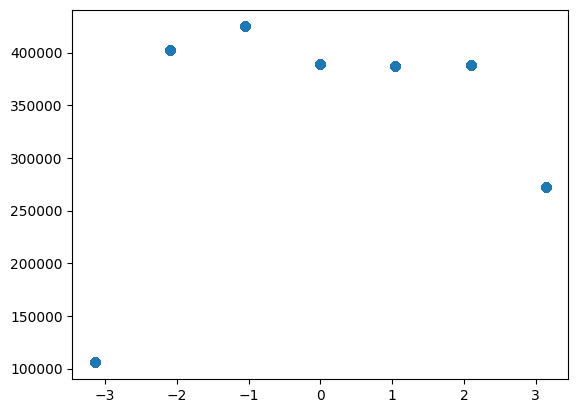

FTemps95_corr1


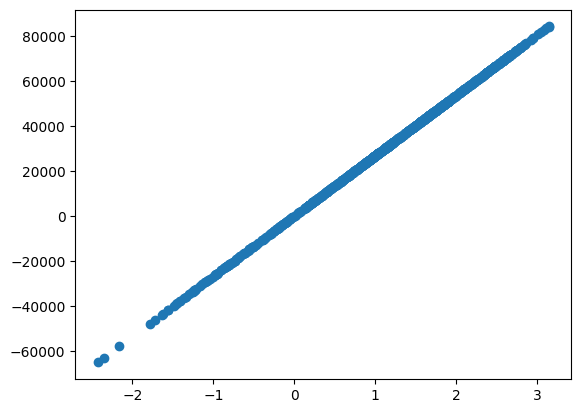

Load2D


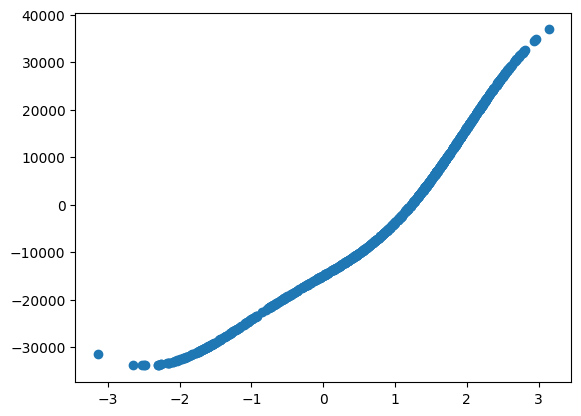

Load1W


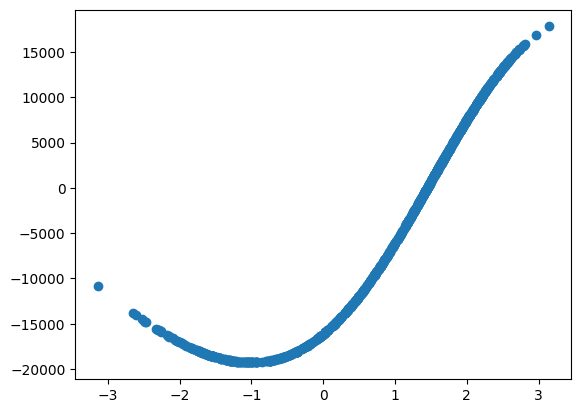

Toy


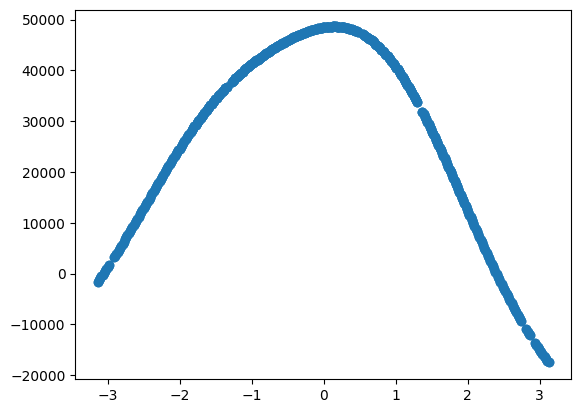

time


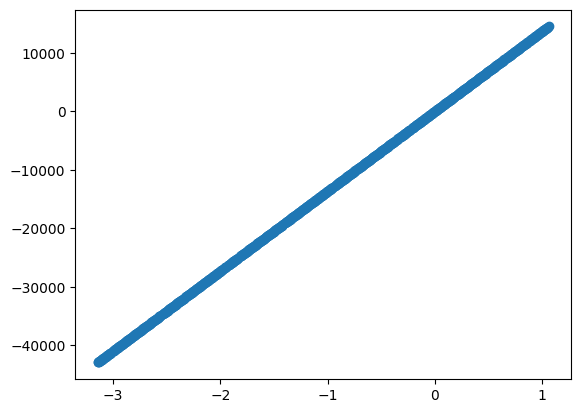

In [67]:
print_effect(data, dates_val, features_weakl, hyperparameters, fourier_vectors, 10)

The MAE offline is 16092.254665644305


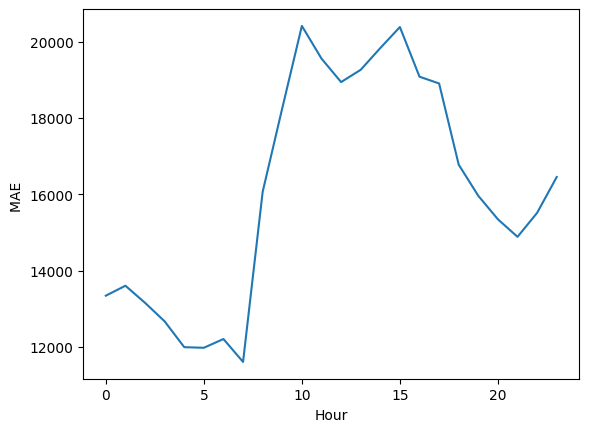

In [68]:
print("The MAE offline is "+str(mae.cpu().numpy()))

plt.figure()
plt.plot(np.array([i for i in range(24)]), np.array(mae_h.cpu()))
plt.xlabel("Hour")
plt.ylabel("MAE ")
plt.show()

### Generate additive WeakL

In [69]:
dates_test = {"begin_train": "2017-03-18",
"end_train": "2020-01-01",
"end_test": "2020-03-01"}

In [70]:
hyperparameters={"m_list":m_list,
                 "s_list":s_list,
                 "alpha_list":alpha_list}

In [71]:
data_hourly = hour_formatting(data, dates_test, features_weakl)
cov_hourly = cov_hourly_m(m_list, data_hourly)
sobolev_matrix = Sob_matrix(alpha_list, s_list, m_list)*len(data_hourly[0][0])
M_stacked = torch.stack([sobolev_matrix for i in range(24)])
mae_test, fourier_vectors_test, mae_h_test = WeakL(data, hyperparameters, cov_hourly, M_stacked)

In [72]:
hyperparameters_test = {"m_list": m_list,
                   "s_list": s_list,
                   "alpha_list": alpha_list,
                   "fourier_vectors": fourier_vectors_test}

#### Additive WeakL error

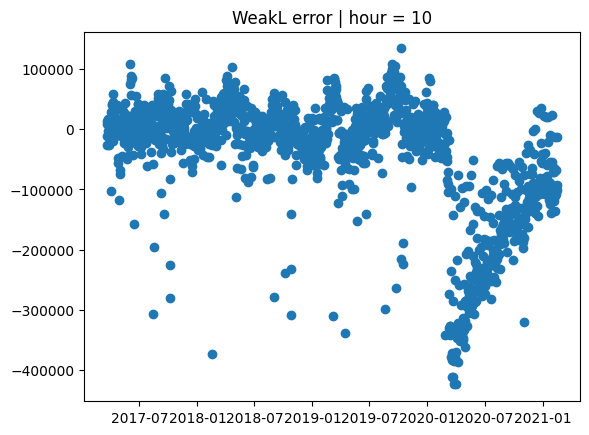

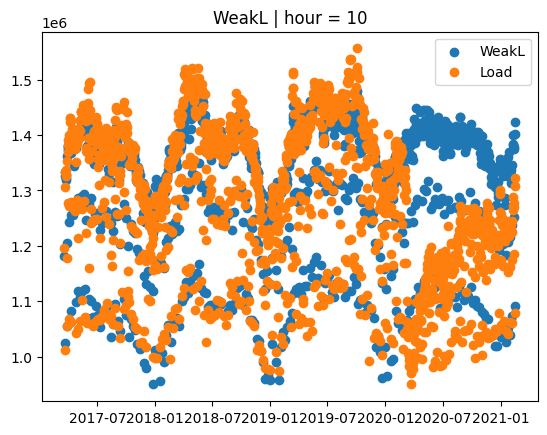

In [73]:
h=10
data_h = data[data['Hour']==h]
data_h.loc[:,features_weakl["features2"]]=normalize(data_h.loc[:,features_weakl["features2"]]).loc[:,features_weakl["features2"]]
estimate = transform(data_h, m_list, fourier_vectors_test[h], features_weakl["features2"])

plt.figure()
plt.title("WeakL error | hour = " + str(h))
plt.scatter(pd.to_datetime(estimate["Time"]), estimate["error"])
plt.show()

plt.figure()
plt.title("WeakL | hour = " + str(h))
plt.scatter(pd.to_datetime(estimate["Time"]), estimate["WeakL"], label="WeakL")
plt.scatter(pd.to_datetime(estimate["Time"]), estimate["Load"], label="Load")
plt.legend()
plt.show()

The mean MAE offline is 19073.626126937765


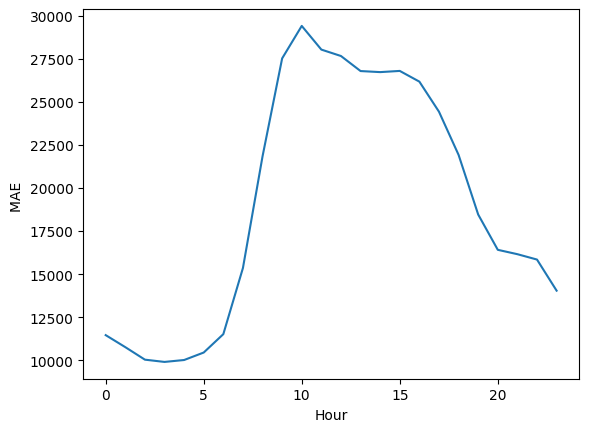

In [74]:
print("The mean MAE offline is "+str(mae_test.cpu().numpy()))

plt.figure()
plt.plot(np.array([i for i in range(24)]), np.array(mae_h_test.cpu()))
plt.xlabel("Hour")
plt.ylabel("MAE ")
plt.show()

## Time-varying WeakL

### Validation online

Time must be the last features of the WeakL for the time-varying WeakL to work.

In [75]:
hyperparameters = hyperparameters_test.copy()

In [76]:
hyperparameters["window"] = 1

dates_val_online = {"begin_train": "2020-02-01",
"end_train": "2020-11-18",
"end_test": "2021-01-18"}

n = len(data[(data['Time']>= dates_val_online["begin_train"])&(data['Time']<dates_val_online["end_train"])])//24
features_weakl["features_type"] = ["regression" for i in range(6)]
features_weakl["masked"] = features_weakl["features_type"].copy()

masked=[1,  3]
for idx in masked:
    features_weakl["features_type"][idx] = "linear"
    features_weakl["masked"][idx] = "masked"

grid_parameters ={
    "grid_size_m": 0,
    "m_ini": 3,
    "grid_size_p": 2,
    "grid_step_p": 1.,
    "batch_size": 2*10**2
}


In [77]:
m_online, alpha_online, s_online, mae_online_val, fourier_online_val, mae_list_opt = grid_search_online(data, dates_val_online, features_weakl, n, grid_parameters, hyperparameters)

0/625
Batch: 0/4
Batch: 1/4
Batch: 2/4
Batch: 3/4


m online =  (3, 'Linear', 3, 'Linear', 3, 3)
alpha online =  tensor([1.0000e-30, 1.0000e+00, 1.0000e+10, 1.0000e+00, 1.0000e+10, 1.0000e-04,
        1.0000e-02], device='cuda:0')
s online =  [2, '*', 2, '*', 2, 2]
MAE validation =  11330.131931031035


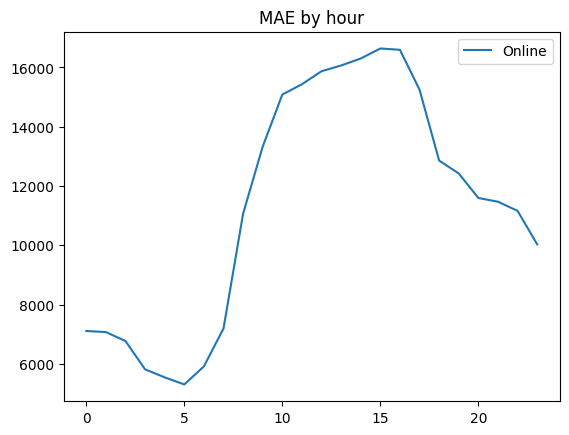

In [78]:
print("m online = ", m_online)
print("alpha online = ", alpha_online)
print("s online = ", s_online)
print("MAE validation = ", mae_online_val.cpu().numpy())
plt.title("MAE by hour")
plt.plot(range(0,24), mae_list_opt.cpu().numpy(), label="Online")
plt.legend()

### Online WeakL adaptation

In [79]:
dates_test_online = {"begin_train": "2017-03-18",
"end_train": "2018-02-04",
"end_test": "2021-02-17"}

hyperparameters_test["window"] = 1

data_hourly = hour_formatting_online(data, dates_test_online, features_weakl, hyperparameters_test)
cov_hourly = cov_hourly_online(m_online, data_hourly)

sobolev_effects = sob_effects(features_weakl, m_online, s_online, len(data_hourly[0][0][0]))
sobolev_effects_online = (sobolev_effects*alpha_online.unsqueeze(-1).unsqueeze(-1)).sum(dim=0)

fourier_online_test= torch.linalg.solve(cov_hourly[0].unsqueeze(0)+sobolev_effects_online, cov_hourly[1].unsqueeze(0))
estimators = torch.matmul(cov_hourly[2].unsqueeze(0), fourier_online_test).squeeze(-1)
errors = torch.abs(cov_hourly[3].unsqueeze(0)-estimators.squeeze(-1))

In [80]:
mae_online =  torch.mean(errors.squeeze(0), dim=1)
mae_mean = torch.mean(mae_online, dim=0)

The MAE online is 25510.29315827396


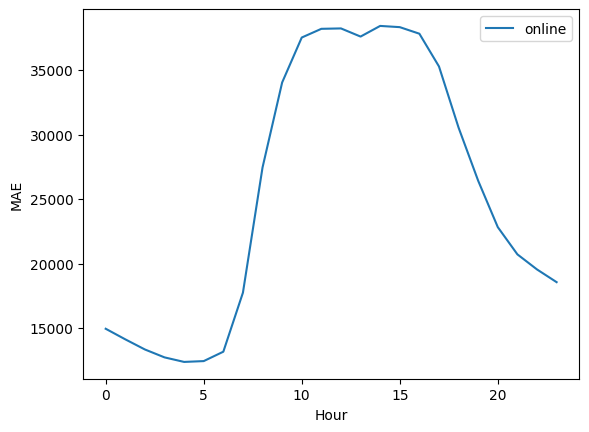

In [81]:
print("The MAE online is "+str(mae_mean.cpu().numpy()))

plt.figure()
plt.plot(np.array([i for i in range(24)]), mae_online.cpu().numpy(), label="online")
#plt.plot(np.array([i for i in range(24)]), mae_h_test.cpu(), label="offline")
plt.xlabel("Hour")
plt.ylabel("MAE")
plt.legend()
plt.show()

## Intraday correction

In [82]:
WeakL_expert = pd.DataFrame()
WeakL_expert['Time']=data['Time']
WeakL_expert['Hour']=data['Hour']
WeakL_expert['Load']=data['Load']
WeakL_expert['WeakL']=np.zeros(len(data['Time']))


In [83]:
def predict_online(parameters_init, X, y, Q=0, sigma=1, delay=1):
    parameters = parameters_init
    d = X.shape[1]
    yhat = np.zeros(len(y))
    theta = parameters['theta']
    P = parameters['P']
    for t in range(len(y)):

        if t >= delay:
            P -= np.outer(P @ X[t-delay, :], P @ X[t-delay, :]) / (sigma**2 + (X[t-delay, :] @ P @ X[t-delay, :]).item())

            theta += P @ X[t-delay, :].T * (y[t-delay] - X[t-delay, :]@theta) / sigma**2

            P += Q
        yhat[t] = (theta.T @ X[t, :]).item()
    return yhat



In [84]:
def intraday_corr(WeakL_expert, online, offline_name = 'WeakL_expert_corr.csv', online_name = 'WeakL_expert_corr_online.csv'):
  for h in range(24):
      mask = data['Hour']==h
      data_h=data[mask]
      if h<8:
          data_h.loc[:,features_weakl["features1"]]=normalize(data_h.loc[:,features_weakl["features1"]]).loc[:,features_weakl["features1"]]
          WeakL_expert.loc[mask,'WeakL']=transform(data_h, m_list, fourier_vectors_test[h], features_weakl["features1"]).loc[:,'WeakL']
      else:
          data_h.loc[:,features_weakl["features2"]]=normalize(data_h.loc[:,features_weakl["features2"]]).loc[:,features_weakl["features2"]]
          WeakL_expert.loc[mask,'WeakL']=transform(data_h, m_list, fourier_vectors_test[h], features_weakl["features2"]).loc[:,'WeakL']
      if online:
          tmp = WeakL_expert.loc[mask,'WeakL'].to_numpy()
          tmp[-estimators.shape[2]:]+=np.real(estimators[0,h,:].cpu().numpy().squeeze())
          WeakL_expert.loc[mask,'WeakL']=tmp

  WeakL_expert_corr = WeakL_expert.copy()
  res = (WeakL_expert_corr['Load']-WeakL_expert_corr['WeakL']).values
  X = np.zeros((WeakL_expert_corr.shape[0], 24))
  for t in range(WeakL_expert_corr.shape[0]):
      start = 24*max(0,(t-1)//24-2)+8
      end = start+24
      X[t,:]=res[start:end]
  d = X.shape[1]
  reshat_static = np.zeros(WeakL_expert_corr.shape[0])
  for h in range(24):
      sel = (WeakL_expert_corr['Hour']==h) & (WeakL_expert_corr['WeakL']!=0)
      reshat_static[sel]= predict_online({'theta':np.zeros(d), 'P':np.identity(d)}, X[sel,:].copy(), res[sel], delay = 1 if h<8 else 2)
  WeakL_expert_corr['WeakL']+=reshat_static

  if online:
    WeakL_expert_corr.to_csv(online_name)
  else:
    WeakL_expert_corr.to_csv(offline_name)
  return WeakL_expert_corr



In [85]:
online = False
WeakL_expert_corr = intraday_corr(WeakL_expert, online, offline_name="WeakL_expert_corr.csv")
test = (WeakL_expert_corr['Time']>="2021-01-18") & (WeakL_expert_corr['Time']<"2021-02-17")
print("WeakL offline ", np.mean(np.abs(WeakL_expert['Load'][test]-WeakL_expert['WeakL'][test])))
print("WeakL offline intraday ", np.mean(np.abs(WeakL_expert_corr['Load'][test]-WeakL_expert_corr['WeakL'][test])))

online = True
WeakL_expert_corr = intraday_corr(WeakL_expert, online, online_name="WeakL_expert_corr_online.csv")
test = (WeakL_expert_corr['Time']>="2021-01-18") & (WeakL_expert_corr['Time']<"2021-02-17")
print("WeakL online ", np.mean(np.abs(WeakL_expert['Load'][test]-WeakL_expert['WeakL'][test])))
print("WeakL online intraday ", np.mean(np.abs(WeakL_expert_corr['Load'][test]-WeakL_expert_corr['WeakL'][test])))

WeakL offline  57950.60303415829
WeakL offline intraday  23352.450489552666
WeakL online  11213.691332412574
WeakL online intraday  11373.41290956066
